# 08.4a: Geometric Time Series

**Compute geometric metrics across all training snapshots**

We have 5,001 snapshots (steps 0-5000) of the embedding matrix evolution, stored in a single consolidated tensor. This notebook computes geometric properties at each step and saves them as time series for analysis.

## Metrics Computed

For each snapshot:
1. **Centroid**: mean position, L2 norm, displacement from previous step
2. **Token norms**: min, max, mean, median, std
3. **Cloud radius**: std of distances from centroid
4. **Dead token statistics**: identify dead tokens (if any), measure their spread
5. **Singularities**: count of unique vectors, number of duplicates

## Parameters

In [17]:
# Input: consolidated embedding history tensor
EMBEDDING_DIR = "../data/embeddings_128vocab_qweninit"  # or embeddings_128vocab_qweninit
EMBEDDING_FILE = "embedding_evolution.safetensors"
EMBEDDING_KEY = "embedding_history"

# Output: time series data
OUTPUT_FILE = "geometric_time_series.safetensors"

# Training run parameters (for validation)
EXPECTED_STEPS = 5001  # Including step 0
VOCAB_SIZE = 128
HIDDEN_DIM = 64

RANDOM_SEED = 42

## Imports

In [18]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load Embedding History

In [19]:
embedding_dir = Path(EMBEDDING_DIR)
embedding_path = embedding_dir / EMBEDDING_FILE

print(f"Loading embedding history from: {embedding_path}")

data = load_file(embedding_path)
embedding_history = data[EMBEDDING_KEY]
n_snapshots, vocab_size, hidden_dim = embedding_history.shape

print(f"\n✓ Embedding history loaded")
print(f"Shape: {embedding_history.shape}")
print(f"Snapshots: {n_snapshots:,}")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Hidden dimension: {hidden_dim:,}")
print(f"Memory footprint: {embedding_history.element_size() * embedding_history.numel() / 1e6:.2f} MB")

# Validate dimensions
if n_snapshots != EXPECTED_STEPS:
    print(f"\n⚠ WARNING: Snapshot count mismatch! Expected {EXPECTED_STEPS:,}, got {n_snapshots:,}")
else:
    print(f"\n✓ Snapshot count matches expectation")

if (vocab_size, hidden_dim) != (VOCAB_SIZE, HIDDEN_DIM):
    raise ValueError(f"Unexpected dimensions: expected ({VOCAB_SIZE}, {HIDDEN_DIM}), got ({vocab_size}, {hidden_dim})")

Loading embedding history from: ../data/embeddings_128vocab_qweninit/embedding_evolution.safetensors

✓ Embedding history loaded
Shape: torch.Size([5001, 128, 64])
Snapshots: 5,001
Vocabulary size: 128
Hidden dimension: 64
Memory footprint: 81.94 MB

✓ Snapshot count matches expectation


## Allocate Time Series Arrays

Pre-allocate arrays for all metrics we'll compute.

In [20]:
# Time series arrays
steps = torch.arange(n_snapshots, dtype=torch.long)

# Centroid metrics
centroid_norm = torch.zeros(n_snapshots)
centroid_displacement = torch.zeros(n_snapshots)  # Displacement from previous step

# Token norm statistics
token_norm_min = torch.zeros(n_snapshots)
token_norm_max = torch.zeros(n_snapshots)
token_norm_mean = torch.zeros(n_snapshots)
token_norm_median = torch.zeros(n_snapshots)
token_norm_std = torch.zeros(n_snapshots)

# Cloud geometry
cloud_radius = torch.zeros(n_snapshots)  # Std of distances from centroid

# Singularity metrics
n_unique_vectors = torch.zeros(n_snapshots, dtype=torch.long)
n_duplicate_tokens = torch.zeros(n_snapshots, dtype=torch.long)
n_singularity_groups = torch.zeros(n_snapshots, dtype=torch.long)

print(f"Allocated time series arrays for {n_snapshots:,} snapshots")
print(f"Memory footprint: ~{n_snapshots * 10 * 8 / 1e6:.2f} MB")

Allocated time series arrays for 5,001 snapshots
Memory footprint: ~0.40 MB


## Compute Metrics

Loop through all snapshots and compute geometric properties.

In [21]:
print(f"\nComputing geometric metrics...\n")

prev_centroid = None

for i in tqdm(range(n_snapshots), desc="Processing snapshots"):
    # Extract embedding matrix for this step
    gamma = embedding_history[i]
    
    # Compute centroid
    centroid = gamma.mean(dim=0)
    centroid_norm[i] = centroid.norm().item()
    
    if prev_centroid is not None:
        centroid_displacement[i] = (centroid - prev_centroid).norm().item()
    else:
        centroid_displacement[i] = 0.0  # First step has no previous
    
    prev_centroid = centroid.clone()
    
    # Token norms
    norms = torch.norm(gamma, p=2, dim=1)
    token_norm_min[i] = norms.min().item()
    token_norm_max[i] = norms.max().item()
    token_norm_mean[i] = norms.mean().item()
    token_norm_median[i] = norms.median().item()
    token_norm_std[i] = norms.std().item()
    
    # Cloud radius (std of distances from centroid)
    distances = torch.norm(gamma - centroid, p=2, dim=1)
    cloud_radius[i] = distances.std().item()
    
    # Singularities
    unique_vectors, inverse_indices, counts = torch.unique(
        gamma, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique_vectors[i] = len(unique_vectors)
    n_duplicate_tokens[i] = vocab_size - len(unique_vectors)
    n_singularity_groups[i] = (counts > 1).sum().item()

print(f"\n✓ Computed metrics for {n_snapshots:,} snapshots")


Computing geometric metrics...



Processing snapshots:   0%|          | 0/5001 [00:00<?, ?it/s]


✓ Computed metrics for 5,001 snapshots


## Summary Statistics

In [22]:
print(f"\n{'='*80}")
print("TIME SERIES SUMMARY")
print(f"{'='*80}\n")

print(f"Steps: {steps[0]} to {steps[-1]}")
print(f"Total snapshots: {n_snapshots:,}")

print(f"\nCentroid norm:")
print(f"  Initial: {centroid_norm[0]:.6f}")
print(f"  Final: {centroid_norm[-1]:.6f}")
print(f"  Max: {centroid_norm.max().item():.6f} (step {steps[centroid_norm.argmax()].item()})")

print(f"\nToken norms (final):")
print(f"  Min: {token_norm_min[-1]:.6f}")
print(f"  Max: {token_norm_max[-1]:.6f}")
print(f"  Mean: {token_norm_mean[-1]:.6f}")
print(f"  Std: {token_norm_std[-1]:.6f}")

print(f"\nCloud radius:")
print(f"  Initial: {cloud_radius[0]:.6f}")
print(f"  Final: {cloud_radius[-1]:.6f}")

print(f"\nSingularities:")
print(f"  Unique vectors (initial): {n_unique_vectors[0]}")
print(f"  Unique vectors (final): {n_unique_vectors[-1]}")
print(f"  Duplicate tokens (initial): {n_duplicate_tokens[0]}")
print(f"  Duplicate tokens (final): {n_duplicate_tokens[-1]}")
print(f"  Singularity groups (final): {n_singularity_groups[-1]}")

print(f"\n{'='*80}")


TIME SERIES SUMMARY

Steps: 0 to 5000
Total snapshots: 5,001

Centroid norm:
  Initial: 1.000000
  Final: 0.816406
  Max: 1.000000 (step 0)

Token norms (final):
  Min: 0.843750
  Max: 1.406250
  Mean: 0.976562
  Std: 0.181641

Cloud radius:
  Initial: 0.000000
  Final: 0.298828

Singularities:
  Unique vectors (initial): 1
  Unique vectors (final): 78
  Duplicate tokens (initial): 127
  Duplicate tokens (final): 50
  Singularity groups (final): 1



## Save Time Series

In [23]:
# Build save dictionary
save_dict = {
    'steps': steps,
    'centroid_norm': centroid_norm,
    'centroid_displacement': centroid_displacement,
    'token_norm_min': token_norm_min,
    'token_norm_max': token_norm_max,
    'token_norm_mean': token_norm_mean,
    'token_norm_median': token_norm_median,
    'token_norm_std': token_norm_std,
    'cloud_radius': cloud_radius,
    'n_unique_vectors': n_unique_vectors,
    'n_duplicate_tokens': n_duplicate_tokens,
    'n_singularity_groups': n_singularity_groups,
}

# Save
output_path = embedding_dir / OUTPUT_FILE
output_path.parent.mkdir(parents=True, exist_ok=True)
save_file(save_dict, output_path)

print(f"✓ Saved time series to: {output_path}")
print(f"\nSaved metrics:")
for key, tensor in save_dict.items():
    print(f"  {key}: {tensor.shape}")

✓ Saved time series to: ../data/embeddings_128vocab_qweninit/geometric_time_series.safetensors

Saved metrics:
  steps: torch.Size([5001])
  centroid_norm: torch.Size([5001])
  centroid_displacement: torch.Size([5001])
  token_norm_min: torch.Size([5001])
  token_norm_max: torch.Size([5001])
  token_norm_mean: torch.Size([5001])
  token_norm_median: torch.Size([5001])
  token_norm_std: torch.Size([5001])
  cloud_radius: torch.Size([5001])
  n_unique_vectors: torch.Size([5001])
  n_duplicate_tokens: torch.Size([5001])
  n_singularity_groups: torch.Size([5001])


## Quick Visualization (Preview)

Generate a quick plot to preview the data. Full analysis will be in 08.5x notebooks.

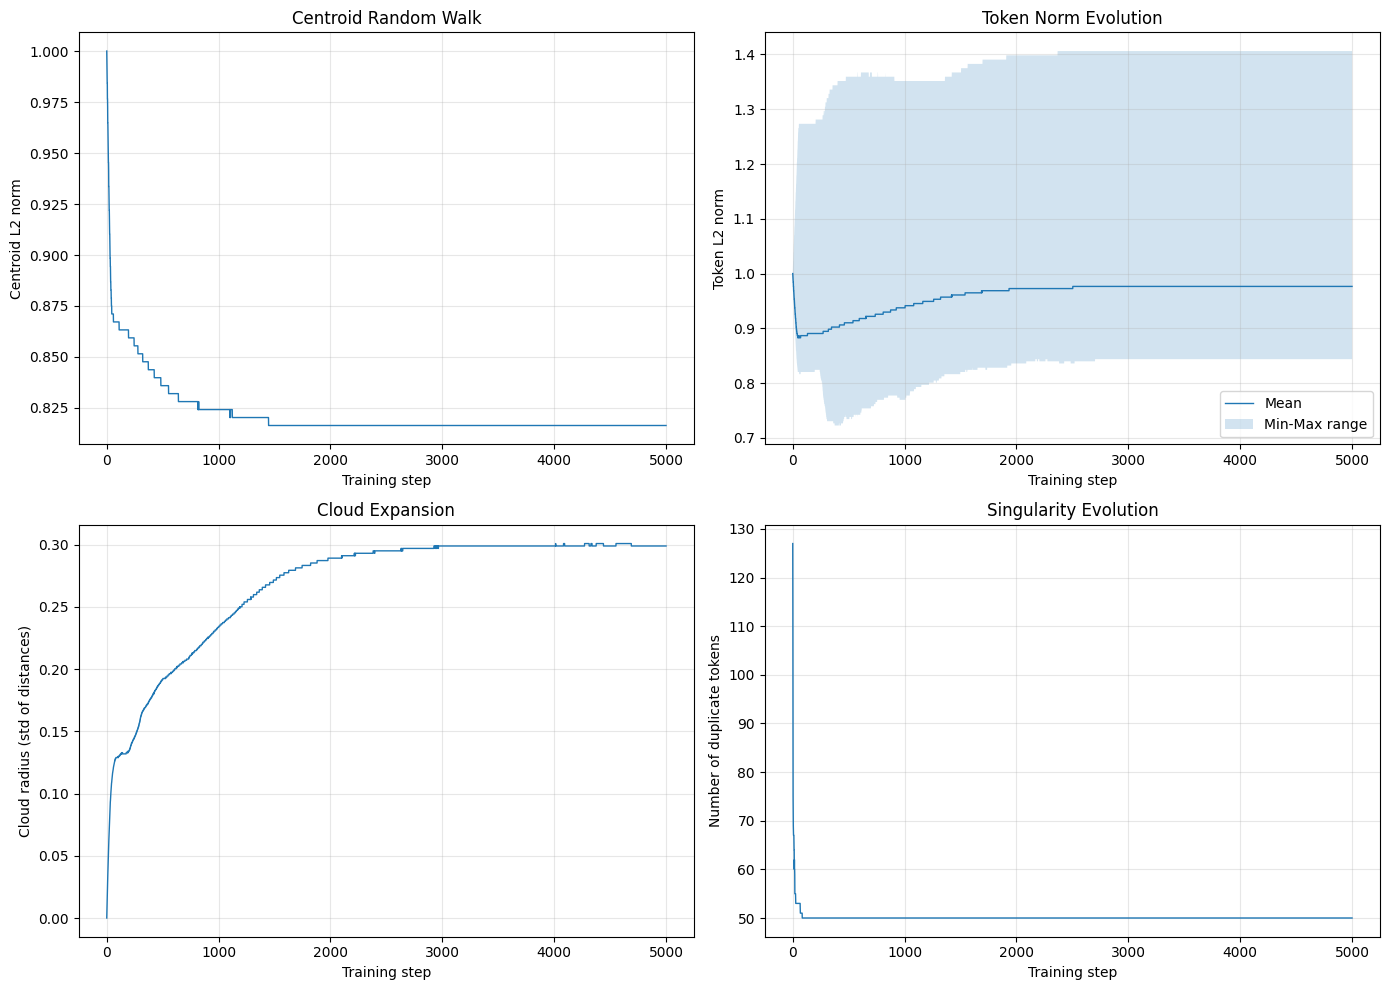


Preview plots generated. For detailed analysis, see 08.5x notebooks.


In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Centroid norm
ax = axes[0, 0]
ax.plot(steps.numpy(), centroid_norm.numpy(), linewidth=1)
ax.set_xlabel('Training step')
ax.set_ylabel('Centroid L2 norm')
ax.set_title('Centroid Random Walk')
ax.grid(True, alpha=0.3)

# Token norms
ax = axes[0, 1]
ax.plot(steps.numpy(), token_norm_mean.numpy(), label='Mean', linewidth=1)
ax.fill_between(steps.numpy(),
                 token_norm_min.numpy(),
                 token_norm_max.numpy(),
                 alpha=0.2, label='Min-Max range')
ax.set_xlabel('Training step')
ax.set_ylabel('Token L2 norm')
ax.set_title('Token Norm Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Cloud radius
ax = axes[1, 0]
ax.plot(steps.numpy(), cloud_radius.numpy(), linewidth=1)
ax.set_xlabel('Training step')
ax.set_ylabel('Cloud radius (std of distances)')
ax.set_title('Cloud Expansion')
ax.grid(True, alpha=0.3)

# Singularities
ax = axes[1, 1]
ax.plot(steps.numpy(), n_duplicate_tokens.numpy(), linewidth=1)
ax.set_xlabel('Training step')
ax.set_ylabel('Number of duplicate tokens')
ax.set_title('Singularity Evolution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPreview plots generated. For detailed analysis, see 08.5x notebooks.")